# Random Forest Implementation

## Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
# recent https://forecast.weather.gov/product.php?site=MFL&issuedby=MIA&product=CLI&format=CI&version=2&glossary=0
# Old https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data


df = pd.read_csv("True values/miami_weather_complete.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
df = df.drop(columns = {"Unnamed: 0", "precipitation",	"mean temp"})
df

,actual_max_temp,min temp,Datetime
0,81.0,63.0,2000-01-01
1,79.0,66.0,2000-01-02
2,80.0,64.0,2000-01-03
3,80.0,71.0,2000-01-04
4,80.0,67.0,2000-01-05
...,...,...,...
9089,72.0,55.0,2024-11-23
9090,78.0,58.0,2024-11-24
9091,82.0,64.0,2024-11-25
9092,84.0,67.0,2024-11-26


In [4]:
openmeteo = pd.read_csv('Open Meteo forecast/MiamiOpenMeteoData.csv')

In [5]:
openmeteo['time'] = pd.to_datetime(openmeteo['time'], format='%m/%d/%y')

# Convert the datetime column back to the desired string format 'DD/MM/YYYY'
openmeteo['time'] = openmeteo['time'].dt.strftime('%m-%d-%Y')

openmeteo = openmeteo.rename(columns = {"time": "Datetime"})
openmeteo['Datetime'] = pd.to_datetime(openmeteo['Datetime'])
openmeteo.dtypes

Datetime                           datetime64[ns]
weather_code (wmo code)                     int64
temperature_2m_max (°F)                   float64
temperature_2m_min (°F)                   float64
temperature_2m_mean (°F)                  float64
apparent_temperature_max (°F)             float64
apparent_temperature_min (°F)             float64
apparent_temperature_mean (°F)            float64
sunrise (iso8601)                          object
sunset (iso8601)                           object
daylight_duration (s)                     float64
sunshine_duration (s)                     float64
precipitation_sum (mm)                    float64
rain_sum (mm)                             float64
snowfall_sum (cm)                         float64
precipitation_hours (h)                     int64
wind_speed_10m_max (mp/h)                 float64
wind_gusts_10m_max (mp/h)                 float64
wind_direction_10m_dominant (°)           float64
shortwave_radiation_sum (MJ/m²)           float64


In [6]:
newdf = pd.merge(df,openmeteo, how = "inner", on = "Datetime")

In [7]:
newdf = newdf.drop(columns = {'sunrise (iso8601)','sunset (iso8601)', 'weather_code (wmo code)'})

In [8]:
newdf['precipitation_hours (h)'] = newdf['precipitation_hours (h)'].astype(float)
newdf = newdf.set_index("Datetime")

In [9]:
newdf = newdf.dropna()

for col in newdf.columns:
            for lag in range(1,2):
                newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)

In [10]:
print(newdf.columns)
correlation_matrix = newdf.corr()
correlation_matrix['actual_max_temp']

Index(['actual_max_temp', 'min temp', 'temperature_2m_max (°F)',
       'temperature_2m_min (°F)', 'temperature_2m_mean (°F)',
       'apparent_temperature_max (°F)', 'apparent_temperature_min (°F)',
       'apparent_temperature_mean (°F)', 'daylight_duration (s)',
       'sunshine_duration (s)', 'precipitation_sum (mm)', 'rain_sum (mm)',
       'snowfall_sum (cm)', 'precipitation_hours (h)',
       'wind_speed_10m_max (mp/h)', 'wind_gusts_10m_max (mp/h)',
       'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)',
       'et0_fao_evapotranspiration (mm)', 'actual_max_temp_lag1',
       'min temp_lag1', 'temperature_2m_max (°F)_lag1',
       'temperature_2m_min (°F)_lag1', 'temperature_2m_mean (°F)_lag1',
       'apparent_temperature_max (°F)_lag1',
       'apparent_temperature_min (°F)_lag1',
       'apparent_temperature_mean (°F)_lag1', 'daylight_duration (s)_lag1',
       'sunshine_duration (s)_lag1', 'precipitation_sum (mm)_lag1',
       'rain_sum (mm)_lag1', 'snow

actual_max_temp                         1.000000
min temp                                0.875829
temperature_2m_max (°F)                 0.962344
temperature_2m_min (°F)                 0.857245
temperature_2m_mean (°F)                0.937416
apparent_temperature_max (°F)           0.947412
apparent_temperature_min (°F)           0.900218
apparent_temperature_mean (°F)          0.941946
daylight_duration (s)                   0.654345
sunshine_duration (s)                   0.375655
precipitation_sum (mm)                  0.069297
rain_sum (mm)                           0.069297
snowfall_sum (cm)                            NaN
precipitation_hours (h)                 0.184858
wind_speed_10m_max (mp/h)              -0.386470
wind_gusts_10m_max (mp/h)              -0.297558
wind_direction_10m_dominant (°)        -0.138839
shortwave_radiation_sum (MJ/m²)         0.505959
et0_fao_evapotranspiration (mm)         0.412372
actual_max_temp_lag1                    0.849278
min temp_lag1       

## Create training sets

In [11]:
def create_train_test(X, y, split):
    split_index = int(len(X) * split) 
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test 

def find_best_random_forest_model(X_train, y_train):
    model = RandomForestRegressor(random_state=42)

    param_grid = {
    'n_estimators': [100],  
    'max_depth': [10, 20],     
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2],           
    'max_features': [None, 'sqrt', 'log2'],  
    'bootstrap': [True]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    return best_model


def get_rf_predictions(model, X_test):
    predictions = model.predict(X_test)
    return predictions

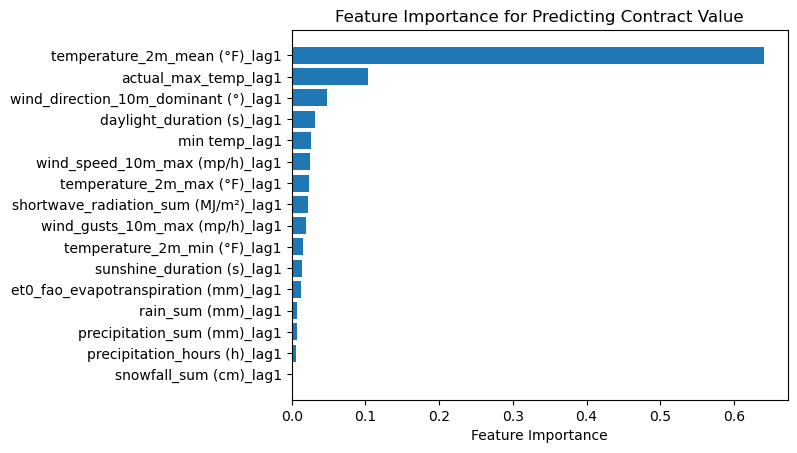

In [12]:
feature_columns = [
        'actual_max_temp_lag1',
       'min temp_lag1', 'temperature_2m_max (°F)_lag1',
       'temperature_2m_min (°F)_lag1', 'temperature_2m_mean (°F)_lag1',
        'daylight_duration (s)_lag1',
       'sunshine_duration (s)_lag1', 'precipitation_sum (mm)_lag1',
       'rain_sum (mm)_lag1', 'snowfall_sum (cm)_lag1',
       'precipitation_hours (h)_lag1', 'wind_speed_10m_max (mp/h)_lag1',
       'wind_gusts_10m_max (mp/h)_lag1',
       'wind_direction_10m_dominant (°)_lag1',
       'shortwave_radiation_sum (MJ/m²)_lag1',
       'et0_fao_evapotranspiration (mm)_lag1'
]

target = 'actual_max_temp'

actualcopy = newdf.copy()


X = actualcopy[feature_columns]
y = actualcopy[target]

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Contract Value')
plt.gca().invert_yaxis()  
plt.show()

In [13]:
create_train_test(X, y, .8)

(            actual_max_temp_lag1  min temp_lag1  temperature_2m_max (°F)_lag1  \
 Datetime                                                                        
 2000-01-01                   NaN            NaN                           NaN   
 2000-01-02                  81.0           63.0                          75.9   
 2000-01-03                  79.0           66.0                          76.1   
 2000-01-04                  80.0           64.0                          76.6   
 2000-01-05                  80.0           71.0                          77.6   
 ...                          ...            ...                           ...   
 2019-11-30                  83.0           67.0                          80.9   
 2019-12-01                  81.0           66.0                          79.9   
 2019-12-02                  85.0           67.0                          81.9   
 2019-12-03                  84.0           59.0                          86.1   
 2019-12-04     

In [ ]:
for i in newdf.columns:
    plt.scatter(newdf['actual_max_temp'], newdf[i])
    plt.xlabel('actual_max_temp')
    plt.ylabel(i)
    plt.show()

## Testing the performance of the Random Forest model

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score:  0.8124362516961545
Mean Squared Error: 7.883091013238177
R² Score: 0.7899939545146715


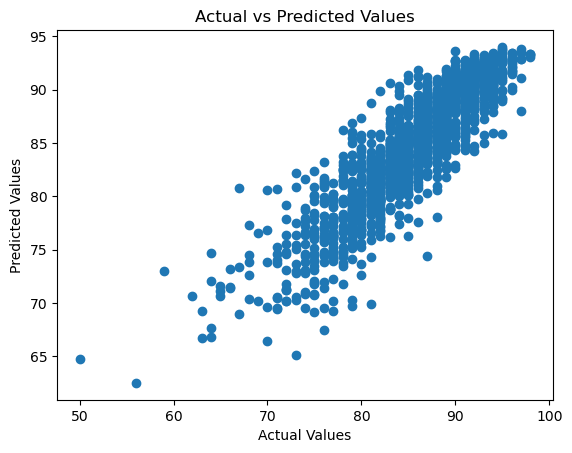

In [17]:
# Step 1: Split Data
X_train, y_train, X_test, y_test = create_train_test(X, y, 0.8)

# Step 2: Train Model with Grid Search (Optional)
best_model = find_best_random_forest_model(X_train, y_train)

# Step 3: Predict on Test Set
predictions = get_rf_predictions(best_model, X_test)

# Step 4: Evaluate the Model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Optional: Visualize Actual vs Predicted
plt.scatter(y_test, predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()
